# Project 1 - Navigation from the Deep Reinforcement Learning Nanodegree of Udacity
---

The task is to train an agent to navigate a flat square world and collect bananas, the world is provided as an Unity environment and is external to the project itself.

A reward of +1 is provided for collecting a yellow banana, and a reward of -1 is provided for collecting a blue banana. Thus, the goal of the agent is to collect as many yellow bananas as possible while avoiding blue bananas.

The task is episodic and, in order to solve the environment, the agent must pick an average score of +13 over 100 consecutive episodes.

### 1. Setup the environment

We begin by importing some necessary packages and starting the Unity environment provided by Udacity. Environments contain **_brains_**, which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [1]:
from unityagents import UnityEnvironment
import gym
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

env = UnityEnvironment(file_name="/home/pedro/deep-reinforcement-learning/p1_navigation/Banana_Linux/Banana.x86_64")

brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


### 2. Essentials of the environment and the agent

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.

The agent is provided in agent.py, and the underlying neural network model in model.py. The goal of the project is to train the agent so that it is able to use its experience to gradually choose better actions when interacting with the environment.

Some information about the environment and basic usage interface of the agent and its interactions with the environment is exemplified here. 

A window should pop up that allows you to observe the agent, as it moves through the environment.

This section can be skipped if the reader is already familiar with the environment, or it can be used to evaluate the trained agents.

In [2]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

# basi interface of the agent
from agent import Agent

agent = Agent(state_size=37, action_size=4, seed=0)
agent.qnetwork_local.load_state_dict(torch.load('model.pth')) # load agent pre-training

env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = agent.act(state, eps=0.0)             # get action (eps=0.0 for trained, eps=1.0 for random actions)
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break

print("Score: {}".format(score))


Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37
Score: 10.0


### 3.  Training

Here we train the agent using the action/reward feedback loop learned in the lessons.

Episode 100	Average Score: 0.96
Episode 200	Average Score: 6.91
Episode 300	Average Score: 11.28
Episode 400	Average Score: 12.97
Episode 401	Average Score: 13.01
Environment solved in 301 episodes!	Average Score: 13.01


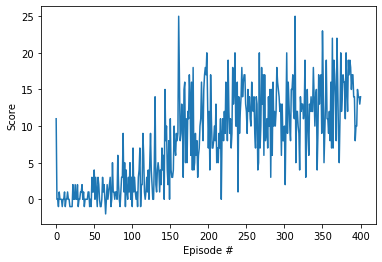

In [3]:
from agent import Agent

agent = Agent(state_size=37, action_size=4, seed=0)
agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))

def dqn(n_episodes=2000, eps_start=0.01, eps_end=0.01, eps_decay=0.995): 
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon (use 0.01 to start from previous weights, 0.99 from scratch)
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        score = 0
        while True:
            action = agent.act(state, eps)                 
            env_info = env.step(action)[brain_name]        
            next_state = env_info.vector_observations[0]   
            reward = env_info.rewards[0]                   
            done = env_info.local_done[0]                 
            agent.step(state, action, reward, next_state, done) 
            score += reward                              
            state = next_state                            
            if done:                                      
                break

        scores_window.append(score)       
        scores.append(score)              
        eps = max(eps_end, eps_decay*eps) 
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
        if np.mean(scores_window)>=13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores

scores = dqn()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()